<a href="https://colab.research.google.com/github/ArTish100/gen-AI-project/blob/main/GenAIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 2.64G/2.64G [01:22<00:00, 32.0MB/s]


Dataset Ready. Example of 'Damaged' vs 'Clean' logic prepared.
Starting Training...
[Epoch 0/5] [Batch 0] [D loss: 0.2584] [G loss: 63.9336]
[Epoch 0/5] [Batch 100] [D loss: 0.0870] [G loss: 19.6184]
[Epoch 1/5] [Batch 0] [D loss: 0.0012] [G loss: 18.6566]
[Epoch 1/5] [Batch 100] [D loss: 0.0034] [G loss: 19.2424]
[Epoch 2/5] [Batch 0] [D loss: 0.1626] [G loss: 18.1638]
[Epoch 2/5] [Batch 100] [D loss: 0.0138] [G loss: 15.5659]
[Epoch 3/5] [Batch 0] [D loss: 0.1952] [G loss: 18.7720]
[Epoch 3/5] [Batch 100] [D loss: 0.2239] [G loss: 15.1165]
[Epoch 4/5] [Batch 0] [D loss: 0.0000] [G loss: 17.6556]
[Epoch 4/5] [Batch 100] [D loss: 0.0000] [G loss: 16.0201]
Training Complete. Visualizing results...


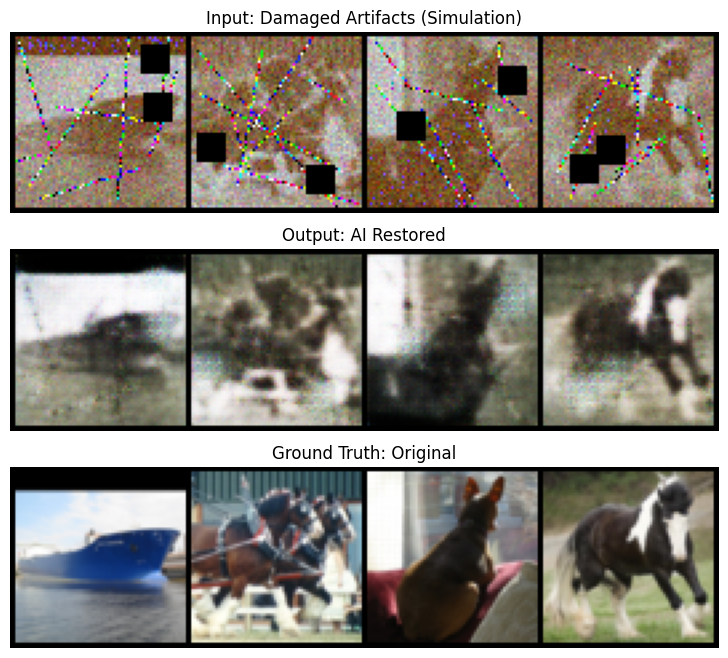

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageOps


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class SimulateArtifactDamage(object):
    """
    Custom transform to simulate aging and damage on cultural artifacts.
    This aligns with the 'Preprocessing' step in the proposal.
    """
    def __init__(self, severity=0.5):
        self.severity = severity

    def __call__(self, img):

        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        w, h = img.size


        img = ImageOps.colorize(ImageOps.grayscale(img), "#704214", "#C0C0C0") # Sepia tint



        from PIL import ImageDraw
        draw = ImageDraw.Draw(img)
        for _ in range(int(10 * self.severity)):
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            color = random.choice(['white', 'black'])
            draw.line((x1, y1, x2, y2), fill=color, width=1)


        img_np = np.array(img)
        noise = np.random.normal(0, 25 * self.severity, img_np.shape).astype(np.uint8)
        img_np = np.clip(img_np + noise, 0, 255)
        img = Image.fromarray(img_np)


        draw = ImageDraw.Draw(img)
        for _ in range(int(3 * self.severity)):
            x = random.randint(0, w-10)
            y = random.randint(0, h-10)
            draw.rectangle([x, y, x+10, y+10], fill='black')

        return transforms.ToTensor()(img)


print("Downloading Dataset (Proxy for Artifacts)...")

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', split='train', download=True):
        self.base_data = datasets.STL10(root=root, split=split, download=download, transform=None)
        self.damage_simulator = SimulateArtifactDamage(severity=0.8)
        self.clean_transform = transform_clean

    def __len__(self):

        return len(self.base_data)

    def __getitem__(self, index):
        clean_pil_original, _ = self.base_data[index]

        resized_pil = transforms.Resize((64, 64))(clean_pil_original)

        real_img = self.clean_transform(resized_pil)


        damaged_img_tensor = self.damage_simulator(resized_pil) # damage_simulator returns a tensor already (0-1 range)

        damaged_img = (damaged_img_tensor - 0.5) / 0.5

        return damaged_img, real_img

dataset = PairedDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print("Dataset Ready. Example of 'Damaged' vs 'Clean' logic prepared.")



class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize: layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(out_feat),
                      nn.ReLU()]
            if dropout: layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        # Encoder
        self.down1 = down_block(3, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        # Decoder
        self.up1 = up_block(512, 256)
        self.up2 = up_block(512, 128)
        self.up3 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u2 = self.up2(torch.cat([u1, d3], 1))
        u3 = self.up3(torch.cat([u2, d2], 1))

        return self.final(torch.cat([u3, d1], 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalization: layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)


        self.model = nn.Sequential(
            discriminator_block(6, 64, normalization=False),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):

        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Initialize Models
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)


criterion_GAN = nn.MSELoss()
criterion_pixel = nn.L1Loss() # Enforces visual similarity

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


num_epochs = 5
lambda_pixel = 100 # Weight for pixel loss

print("Starting Training...")

for epoch in range(num_epochs):
    for i, (damaged, real) in enumerate(dataloader):

        damaged = damaged.to(device)
        real = real.to(device)


        optimizer_G.zero_grad()

        fake = generator(damaged)


        pred_fake = discriminator(damaged, fake)
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))


        loss_pixel = criterion_pixel(fake, real)


        loss_G = loss_GAN + (lambda_pixel * loss_pixel)
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(damaged, real)
        loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = discriminator(damaged, fake.detach())
        loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")



def show_results():
    generator.eval()
    with torch.no_grad():
        # Get a sample batch
        damaged, real = next(iter(dataloader))
        damaged = damaged.to(device)
        real = real.to(device)

        fake = generator(damaged)

        # Move to CPU for plotting
        damaged = damaged.cpu()
        real = real.cpu()
        fake = fake.cpu()

        # Create a grid: Row 1 = Damaged, Row 2 = Restored (AI), Row 3 = Original
        img_grid_damaged = vutils.make_grid(damaged[:4], nrow=4, normalize=True)
        img_grid_fake = vutils.make_grid(fake[:4], nrow=4, normalize=True)
        img_grid_real = vutils.make_grid(real[:4], nrow=4, normalize=True)

        plt.figure(figsize=(15, 8))

        plt.subplot(3, 1, 1)
        plt.axis("off")
        plt.title("Input: Damaged Artifacts (Simulation)")
        plt.imshow(np.transpose(img_grid_damaged, (1, 2, 0)))

        plt.subplot(3, 1, 2)
        plt.axis("off")
        plt.title("Output: AI Restored")
        plt.imshow(np.transpose(img_grid_fake, (1, 2, 0)))

        plt.subplot(3, 1, 3)
        plt.axis("off")
        plt.title("Ground Truth: Original")
        plt.imshow(np.transpose(img_grid_real, (1, 2, 0)))

        plt.show()

print("Training Complete. Visualizing results...")
show_results()